# Data and Library Import

In [1]:
# library import
import pandas as pd
import numpy as np
from scipy.stats import norm
from datetime import datetime
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, StandardScaler, 
                                   MinMaxScaler, PowerTransformer, QuantileTransformer)
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import PredictionError
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
df = pd.read_csv('/content/drive/MyDrive/project/insuarance.csv', index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


- 결측치는 없음
- 성별,흡연여부,거주지역을 제외한 컬럼은 정수와 실수

In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


- children 변수의 평균과 표준편차가 비슷함
  분포가 매우 넓게 퍼져 있어서 히스토그램을 통해 살펴본 후 분포를 조정

- charges 변수 수의 크기가 다른 변수들과 차이가 매우 크지만,
  종속변수이므로 따로 scaling은 해주지 않는다.

In [6]:
df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


- age의 분포가 18세, 19세에 많이 몰려있음.  
  children의 수가 0인 표본이 많은 것,  
  smoker 응답이 no(비흡연자)가 압도적으로 많은 것과 연결되는 것 같다.  
  분포를 생각해서 train test split 필요

- sex와 region의 분포는 범주별로 비슷하게 분포하고 있다.

In [7]:
children = df.groupby("children", as_index=False)["age","bmi","charges"].mean().sort_values("age",ascending=False).style.background_gradient("Blues")
print("Average value of other properties by children \n")
children

Average value of other properties by children 



,children,age,bmi,charges
3,3,41.566879,30.684331,15355.318367
1,1,39.453704,30.623148,12731.171832
2,2,39.445833,30.978104,15073.563734
4,4,39.000000,31.391200,13850.656311
0,0,38.444251,30.550296,12365.975602
5,5,35.611111,29.605000,8786.035247


- children(자녀의 수) 변수가 5인 경우 charges 변수가 많이 낮다.
자녀가 5명인 부부의 평균연령이 낮고, bmi지수가 낮다.


##EDA-(1) 나이 변수에 따른 특징

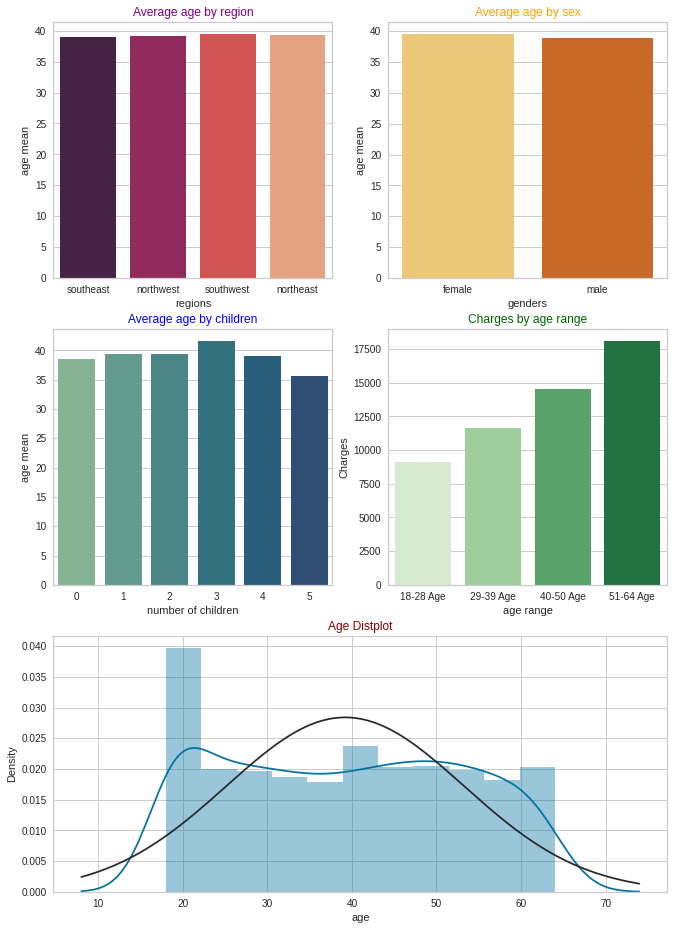

In [8]:
regions = ["southeast","northwest","southwest","northeast"]
children = [0,1,2,3,4,5]
genders = ["female", "male"]

regionAgeMean = []
sexAgeMean = []
childAgeMean = []

for region in regions:
  x = df[df["region"] == region]
  ageMeanRegion = x["age"].mean()
  regionAgeMean.append(ageMeanRegion)
    
for gender in genders:
  y = df[df["sex"] == gender]
  ageMeanSex = y["age"].mean()
  sexAgeMean.append(ageMeanSex)

for child in children:
  z = df[df["children"] == child]
  ageMeanChild = z["age"].mean()
  childAgeMean.append(ageMeanChild)

ageFirstDecember = df[df["age"].between(18,28, inclusive = True)]["charges"].mean()
ageSecondDecember = df[df["age"].between(29,39, inclusive = True)]["charges"].mean()
ageThirdDecember = df[df["age"].between(40,50, inclusive = True)]["charges"].mean()
ageFourthDecember = df[df["age"].between(51,64, inclusive = True)]["charges"].mean()

averageAge = [ageFirstDecember,ageSecondDecember,ageThirdDecember,ageFourthDecember]
ageRanges = ["18-28 Age","29-39 Age","40-50 Age","51-64 Age"]

plt.figure(figsize=(11,16))
plt.subplot(3,2,1)
sns.barplot(x = regions, y = regionAgeMean, palette= "rocket")
plt.title("Average age by region", color = "purple")
plt.xlabel("regions")
plt.ylabel("age mean")
plt.subplot(3,2,2)
sns.barplot(x = genders, y = sexAgeMean, palette="YlOrBr")
plt.title("Average age by sex", color = "orange")
plt.xlabel("genders")
plt.ylabel("age mean")
plt.subplot(3,2,3)
sns.barplot(x = children, y = childAgeMean, palette="crest")
plt.title("Average age by children", color = "blue")
plt.xlabel("number of children")
plt.ylabel("age mean")
plt.subplot(3,2,4)
sns.barplot(x=ageRanges, y=averageAge, palette="Greens")
plt.title("Charges by age range", color = "darkgreen")
plt.xlabel("age range")
plt.ylabel("Charges")
plt.subplot(3,2,(5,6))
sns.distplot(df["age"], fit=norm)
plt.title("Age Distplot", color = "darkred")

plt.show()


- 지역별 평균 연령은 크게 차이가 나지 않는다
- 성별에 따른 평균 연령은 크게 차이가 나지 않는다.
- 5명의 자녀를 둔 사람들의 평균 연령이 제일 낮다.
- 10세 단위로 연령을 범주화 했을 때, 연령이 올라갈수록 가장 높은 charges

##EDA-(2) 성별 변수에 따른 특징

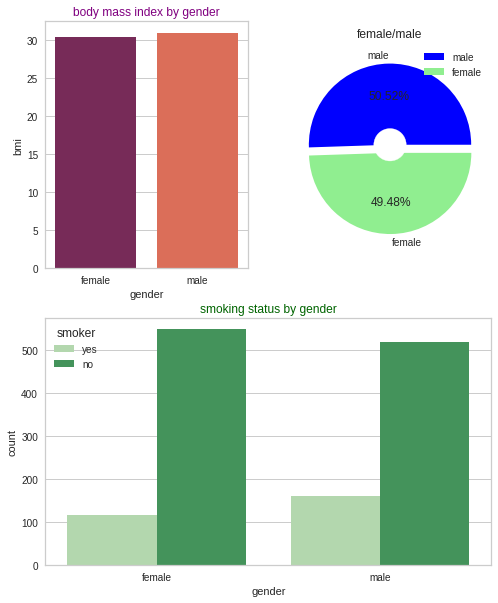

In [9]:

bodyMassIndex = []
for i in genders:
    sex = df[df["sex"] == i]
    bmi = sex["bmi"].mean()
    bodyMassIndex.append(bmi)
    
totalNumber = df.sex.value_counts().values
genderLabel = df.sex.value_counts().index
circle = plt.Circle((0,0),0.2,color = "white") 
explode = (0, 0.1)

plt.figure(figsize=(8,10))
plt.subplot(2,2,1)
sns.barplot(x = genders, y = bodyMassIndex, palette= "rocket")
plt.title("body mass index by gender", color = "purple")
plt.xlabel("gender")
plt.ylabel("bmi")
plt.subplot(2,2,2)
plt.pie(totalNumber, labels = genderLabel,autopct='%1.2f%%', explode = explode, colors=['blue','lightgreen'])
p = plt.gcf()
p.gca().add_artist(circle) 
plt.title("female/male")
plt.legend()
plt.subplot(2,2,(3,4))
sns.countplot(x = 'sex', hue = 'smoker', data = df, palette="Greens")
plt.title("smoking status by gender", color = "darkgreen")
plt.xlabel("gender")
plt.show()

- 성별에 따른 BMI지수는 큰 차이를 보이지 않는다.
- 성별의 분포는 큰 차이를 보이지 않는다.
- 성별에 따른 흡연여부는 큰 차이를 보이지 않는다.

##EDA-(3) 흡연 변수에 따른 특징

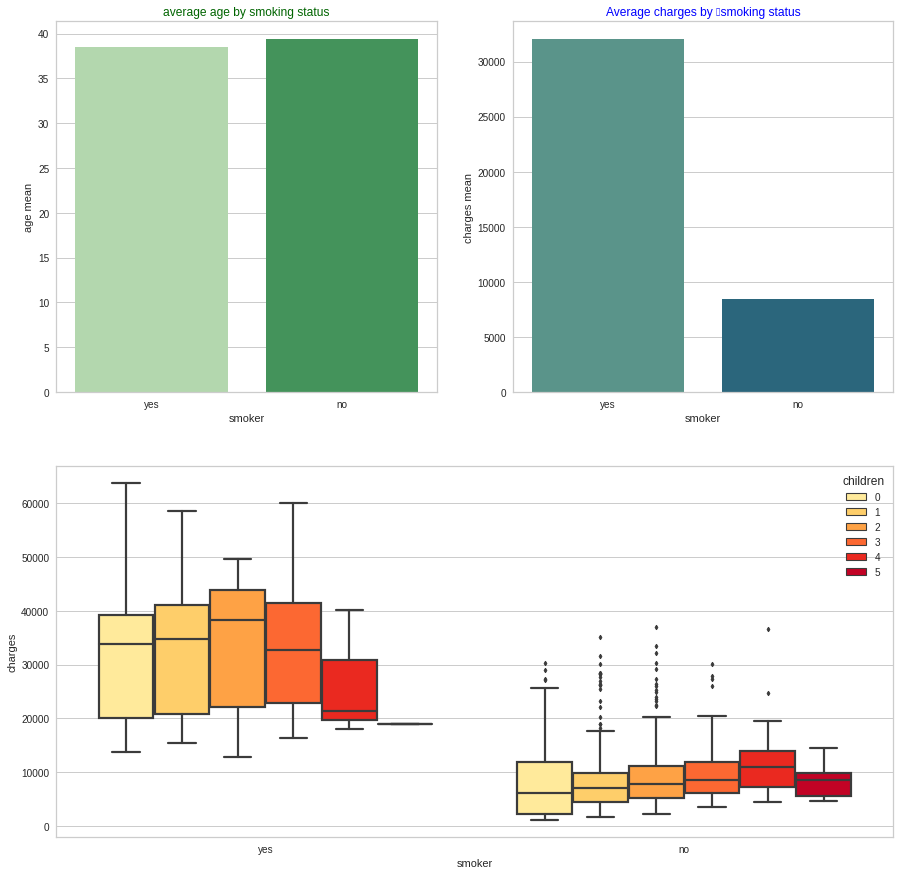

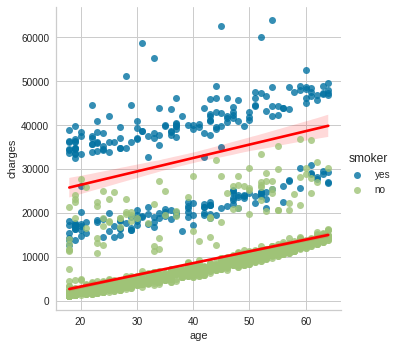

In [10]:
smoker = ["yes", "no"]

smokerAge = []
smokerCharges = []

for each in smoker:
    smokerDistinction = df[df["smoker"] == each]
    xxx = smokerDistinction["age"].mean()
    yyy = smokerDistinction["charges"].mean()
    smokerAge.append(xxx)
    smokerCharges.append(yyy)

    
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.barplot(x = smoker, y = smokerAge, palette= "Greens")
plt.title("average age by smoking status", color = "darkgreen")
plt.xlabel("smoker")
plt.ylabel("age mean")
plt.subplot(2,2,2)
sns.barplot(x = smoker, y = smokerCharges, palette="crest")
plt.title("Average charges by smoking status", color = "blue")
plt.xlabel("smoker")
plt.ylabel("charges mean")
plt.subplot(2,2,(3,4))
sns.boxplot(x="smoker", y="charges", hue="children", linewidth=2.2, fliersize= 3.2 ,data=df, saturation=1, palette="YlOrRd")

sns.lmplot(x='age', y='charges', hue='smoker', data=df, line_kws={'color': 'red'})

plt.show()

- 흡연 여부에 따른 평균연령은 큰 차이가 나지 않는다.
- 흡연자가 비흡연자보다 훨씬 더 많은 charges

흡연은 보험료에 영향을 미친다.  
흡연여부는 지역에 상관 없이 영향을 미치는지 그래프

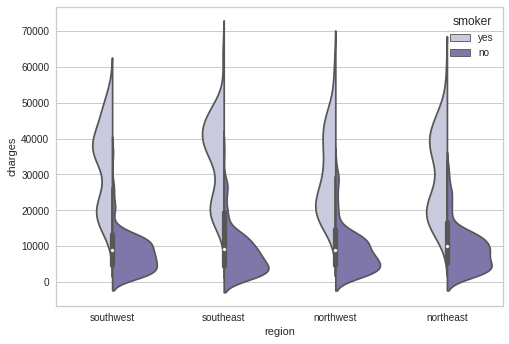

In [11]:
sns.violinplot(y = df.charges, x = df.region, hue = df.smoker, split=True, palette='Purples')
plt.show()

- 지역은 크게 상관이 없다.

흡연여부와 BMI지수는 요금과 어떤 관계가 있는지 그래프

<Figure size 576x576 with 0 Axes>

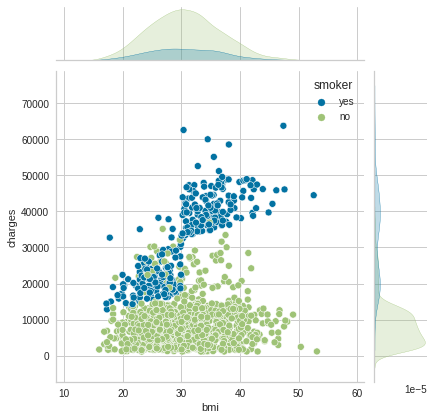

In [12]:
plt.figure(figsize=(8,8))
sns.jointplot(x = df.bmi, y = df.charges, hue = df.smoker)
plt.show()

- 보혐료 : 비흡연자 < 흡연자+정상체중 < 흡연자+비만 

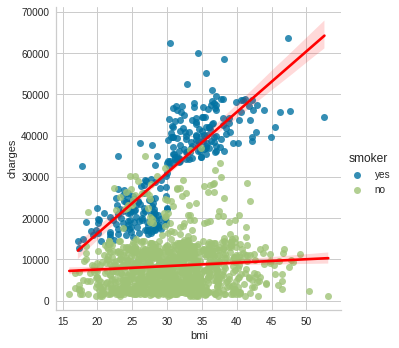

In [13]:
sns.lmplot(data=df,x='bmi',y='charges',hue='smoker',line_kws={'color': 'red'})

- bmi지수는 흡연자일 경우 더 큰 영향을 미친다.

##EDA-(4) charges 변수의 분포

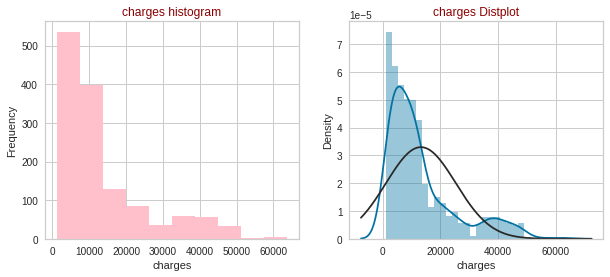

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df["charges"], color="pink")
plt.xlabel("charges")
plt.ylabel("Frequency")
plt.title("charges histogram", color = "darkred")
plt.subplot(1,2,2)
sns.distplot(df["charges"], fit=norm)
plt.title("charges Distplot", color = "darkred")

plt.show()

#Feature Engineering

1. 성별, 흡연여부, 지역, 자녀의 수 변수는 One-Hot Encoding
2. charges변수는 분포가 치우쳐 있기 때문에 정규화

In [15]:
change_col = ['sex','smoker','region','children']
onehot = pd.get_dummies(df,columns=change_col,dtype='int8')

In [16]:
onehot.head(10)

,age,bmi,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,children_0,children_1,children_2,children_3,children_4,children_5
0,19,27.900,16884.92400,1,0,0,1,0,0,0,1,1,0,0,0,0,0
1,18,33.770,1725.55230,0,1,1,0,0,0,1,0,0,1,0,0,0,0
2,28,33.000,4449.46200,0,1,1,0,0,0,1,0,0,0,0,1,0,0
3,33,22.705,21984.47061,0,1,1,0,0,1,0,0,1,0,0,0,0,0
4,32,28.880,3866.85520,0,1,1,0,0,1,0,0,1,0,0,0,0,0
5,31,25.740,3756.62160,1,0,1,0,0,0,1,0,1,0,0,0,0,0
6,46,33.440,8240.58960,1,0,1,0,0,0,1,0,0,1,0,0,0,0
7,37,27.740,7281.50560,1,0,1,0,0,1,0,0,0,0,0,1,0,0
8,37,29.830,6406.41070,0,1,1,0,1,0,0,0,0,0,1,0,0,0
9,60,25.840,28923.13692,1,0,1,0,0,1,0,0,1,0,0,0,0,0


In [17]:
onehot["log_charges"] = np.log1p(onehot["charges"])
df["log_charges"] = np.log1p(df["charges"])

In [18]:
from scipy import stats

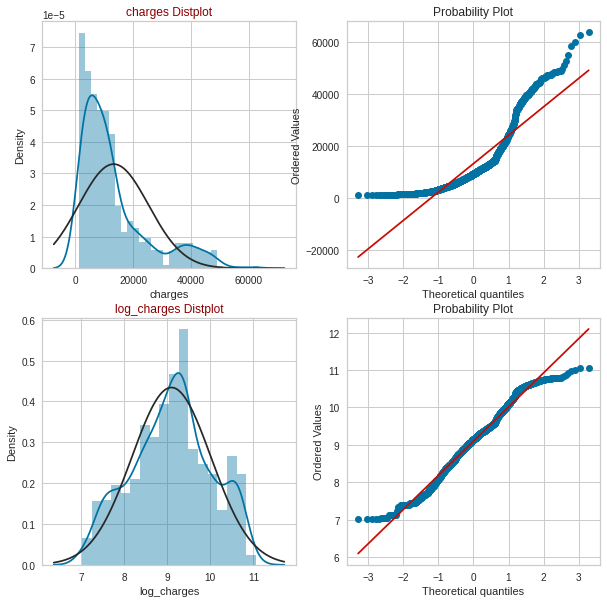

In [19]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sns.distplot(df["charges"], fit=norm)
plt.title("charges Distplot", color = "darkred")

plt.subplot(2,2,2)
stats.probplot(df["charges"], plot = plt)

plt.subplot(2,2,3)
sns.distplot(df["log_charges"], fit=norm)
plt.title("log_charges Distplot", color = "darkred")

plt.subplot(2,2,4)
stats.probplot(df["log_charges"], plot = plt)

plt.show()

#Modeling

In [20]:
y = onehot.log_charges
X = onehot.drop(["charges","log_charges"], axis = 1)

In [44]:
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = test_size, random_state = 20)

In [45]:
print("X_train shape {}, len {}.".format(X_train.shape,len(X_train)))
print("X_test shape {}, len {}.".format(X_test.shape,len(X_test)))
print("Y_train shape {}, len {}.".format(Y_train.shape,len(Y_train)))
print("Y_test shape {}, len {}.".format(Y_test.shape,len(Y_test)))

X_train shape (1070, 16), len 1070.
X_test shape (268, 16), len 268.
Y_train shape (1070,), len 1070.
Y_test shape (268,), len 268.


In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 

In [47]:
result = []

##Linear Regression

In [48]:
multiple_linear = LinearRegression()
multiple_linear.fit(X_train, Y_train)
predict = multiple_linear.predict(X_test)
score = r2_score(Y_test,predict)
result.append(score)

In [49]:
print("r_square score --> ",score)
print('Mean Absolute Error -->', metrics.mean_absolute_error(Y_test, predict))
print('Mean Squared Error -->', metrics.mean_squared_error(Y_test, predict))
print('Root Mean Squared Error -->', np.sqrt(metrics.mean_squared_error(Y_test, predict)))

r_square score -->  0.8289133849032041
Mean Absolute Error --> 0.2666385922294565
Mean Squared Error --> 0.1468898965983282
Root Mean Squared Error --> 0.3832621773646967


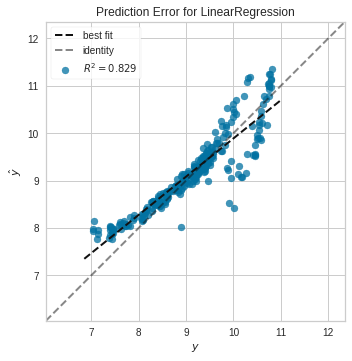

In [50]:
visualizer = PredictionError(multiple_linear)
visualizer.fit(X_train, Y_train)  
visualizer.score(X_test, Y_test)        
visualizer.show();

##Random Forest

In [51]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

rf_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [52]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)
rf_predict = rf_random.predict(X_test)
score_rf = r2_score(Y_test,rf_predict)
result.append(score_rf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [53]:
print("r_square score --> ",score_rf)
print('Mean Absolute Error -->', metrics.mean_absolute_error(Y_test, rf_predict))
print('Mean Squared Error -->', metrics.mean_squared_error(Y_test, rf_predict))
print('Root Mean Squared Error -->', np.sqrt(metrics.mean_squared_error(Y_test, rf_predict)))

r_square score -->  0.9111311058916982
Mean Absolute Error --> 0.16198719573133397
Mean Squared Error --> 0.07630019834684725
Root Mean Squared Error --> 0.27622490537032907


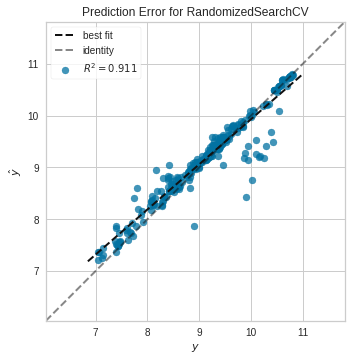

In [54]:
visualizer = PredictionError(rf_random)
visualizer.fit(X_train, Y_train)  
visualizer.score(X_test, Y_test)        
visualizer.show();

##XGB Regression

In [55]:
xgb =  XGBRegressor(max_depth = 2, learning_rate = .2)
xgb.fit(X_train,Y_train)
xgb_predict = xgb.predict(X_test)
score_xgb = r2_score(Y_test,xgb_predict)
result.append(score_xgb)

[16:44:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [56]:
print("r_square score --> ",score_xgb)
print('Mean Absolute Error -->', metrics.mean_absolute_error(Y_test, xgb_predict))
print('Mean Squared Error -->', metrics.mean_squared_error(Y_test, xgb_predict))
print('Root Mean Squared Error -->', np.sqrt(metrics.mean_squared_error(Y_test, xgb_predict)))

r_square score -->  0.9146703699511524
Mean Absolute Error --> 0.17218685583930565
Mean Squared Error --> 0.07326149113159677
Root Mean Squared Error --> 0.27066860019514044


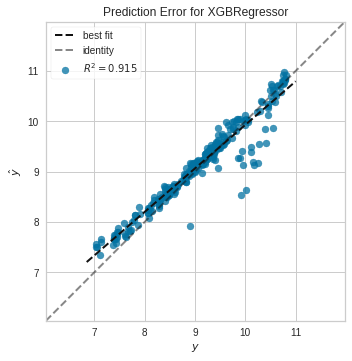

In [57]:
visualizer = PredictionError(xgb)
visualizer.fit(X_train, Y_train)  
visualizer.score(X_test, Y_test)        
visualizer.show();

##Ridge Regression

In [58]:
ridge = Ridge()
ridge.fit(X_train,Y_train)
ridge_predict = ridge.predict(X_test)
score_ridge = r2_score(Y_test,ridge_predict)
result.append(score_ridge)

In [59]:
print("r_square score --> ",score_ridge)
print('Mean Absolute Error -->', metrics.mean_absolute_error(Y_test, ridge_predict))
print('Mean Squared Error -->', metrics.mean_squared_error(Y_test, ridge_predict))
print('Root Mean Squared Error -->', np.sqrt(metrics.mean_squared_error(Y_test, ridge_predict)))

r_square score -->  0.8281706234831543
Mean Absolute Error --> 0.26556570643570265
Mean Squared Error --> 0.14752760953762864
Root Mean Squared Error --> 0.38409323026789816


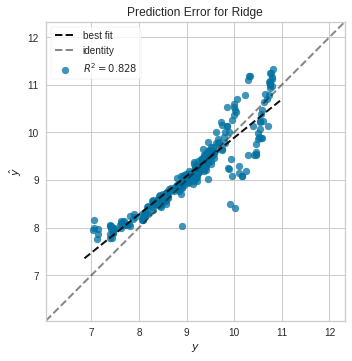

In [60]:
visualizer = PredictionError(ridge)
visualizer.fit(X_train, Y_train)  
visualizer.score(X_test, Y_test)        
visualizer.show();

##KNN

In [61]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, Y_train)
knn_predict = knn.predict(X_test)
score_knn = r2_score(Y_test,knn_predict)
result.append(score_knn)

In [62]:
print("r_square score --> ",score_knn)
print('Mean Absolute Error -->', metrics.mean_absolute_error(Y_test, knn_predict))
print('Mean Squared Error -->', metrics.mean_squared_error(Y_test, knn_predict))
print('Root Mean Squared Error -->', np.sqrt(metrics.mean_squared_error(Y_test, knn_predict)))

r_square score -->  0.8371182023334395
Mean Absolute Error --> 0.2618217316599221
Mean Squared Error --> 0.13984548354910417
Root Mean Squared Error --> 0.3739592003803412


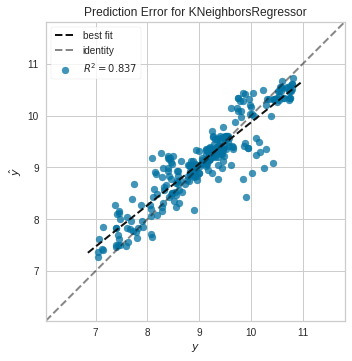

In [63]:
visualizer = PredictionError(knn)
visualizer.fit(X_train, Y_train)  
visualizer.score(X_test, Y_test)        
visualizer.show();

##Gradient Boosting Regression

In [64]:
gbr = GradientBoostingRegressor(max_depth=3, random_state=42)
gbr.fit(X_train, Y_train)
gbr_predict = gbr.predict(X_test)
score_gbr = r2_score(Y_test,gbr_predict)
result.append(score_gbr)

In [65]:
print("r_square score --> ",score_gbr)
print('Mean Absolute Error -->', metrics.mean_absolute_error(Y_test, gbr_predict))
print('Mean Squared Error -->', metrics.mean_squared_error(Y_test, gbr_predict))
print('Root Mean Squared Error -->', np.sqrt(metrics.mean_squared_error(Y_test, gbr_predict)))

r_square score -->  0.9158260932080351
Mean Absolute Error --> 0.1646094289248153
Mean Squared Error --> 0.07226922139966169
Root Mean Squared Error --> 0.2688293536793586


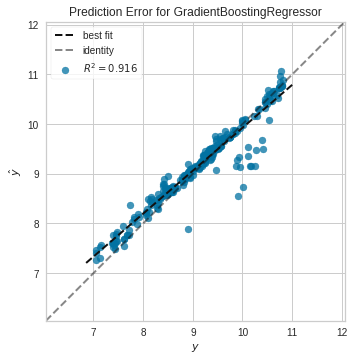

In [66]:
visualizer = PredictionError(gbr)
visualizer.fit(X_train, Y_train)  
visualizer.score(X_test, Y_test)        
visualizer.show();

#Model Result

In [68]:
df_result = pd.DataFrame({"Score":result, "ML Models":["LinearRegression","RandomForestRegression",
             "XGBRegression", "RidgeRegression","KNN Regression","Gradient Boosting Regression"]})

In [72]:
df_result = df_result.sort_values(by='Score', ascending=False)

In [75]:
df_result.reset_index(drop=True, inplace=True)

In [76]:
df_result

,Score,ML Models
0,0.915826,Gradient Boosting Regression
1,0.914670,XGBRegression
2,0.911131,RandomForestRegression
3,0.837118,KNN Regression
4,0.828913,LinearRegression
5,0.828171,RidgeRegression


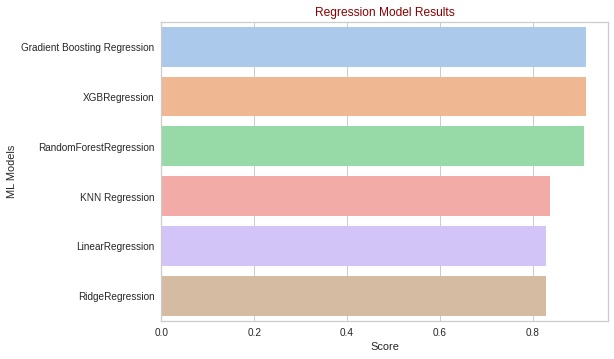

In [83]:
sns.set_palette("pastel")
g = sns.barplot("Score", "ML Models", data = df_result)
g.set_xlabel("Score")
g.set_title("Regression Model Results", color = "darkred")
plt.show()

In [85]:
import joblib

In [86]:
joblib.dump(gbr, 'gbr.pkl')

['gbr.pkl']